In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("data/sp500_stocks.csv")
data=data[data['Symbol']=='MMM']
data.drop(['Symbol'], axis=1, inplace=True)
date_column='Date'
target_column='Close'
data

,Date,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,46.422302,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,46.131523,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,46.785759,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,46.819294,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,47.149204,70.501671,70.501671,69.648827,69.974915,4073337.0
...,...,...,...,...,...,...,...
3605,2024-05-01,98.440002,98.440002,99.699997,97.279999,98.099998,11062600.0
3606,2024-05-02,96.809998,96.809998,98.400002,96.650002,97.959999,6317100.0
3607,2024-05-03,97.150002,97.150002,98.190002,96.839996,97.580002,4818500.0
3608,2024-05-06,96.589996,96.589996,97.750000,96.540001,97.089996,4329500.0


In [5]:
data['Date'] = pd.to_datetime(data['Date'])
monthly_avg = data.groupby(pd.Grouper(key='Date', freq='M')).mean()
monthly_avg.reset_index(inplace=True)
monthly_avg['Date'] = monthly_avg['Date'].dt.year.astype(str) + '-01-01'
data=monthly_avg.copy()

In [6]:
data

,Date,Adj Close,Close,High,Low,Open,Volume
0,2010-01-01,46.409345,69.395353,70.013202,68.794226,69.567418,4.734152e+06
1,2010-01-01,44.824470,66.802940,67.274248,66.134042,66.814822,4.722337e+06
2,2010-01-01,46.098352,68.392467,68.796350,67.871529,68.277592,4.735437e+06
3,2010-01-01,48.091365,71.349340,71.802039,70.783962,71.270903,5.490608e+06
4,2010-01-01,47.170385,69.780935,70.843227,68.449833,70.097408,6.552501e+06
...,...,...,...,...,...,...,...
168,2024-01-01,86.860169,86.860169,87.838429,85.963529,87.148032,5.641037e+06
169,2024-01-01,77.616639,77.616639,78.110369,76.964465,77.602425,4.631181e+06
170,2024-01-01,84.071907,84.071907,84.895067,83.097826,83.770067,8.078986e+06
171,2024-01-01,92.267728,92.267728,93.245454,91.181819,92.221363,5.082609e+06


In [7]:
# data.to_csv("processedData.csv",index=False)
# data = pd.read_csv("processedData.csv")
# data

## Pre Processing

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       173 non-null    object 
 1   Adj Close  173 non-null    float64
 2   Close      173 non-null    float64
 3   High       173 non-null    float64
 4   Low        173 non-null    float64
 5   Open       173 non-null    float64
 6   Volume     173 non-null    float64
dtypes: float64(6), object(1)
memory usage: 9.6+ KB


In [9]:
data.dropna(inplace=True)
data.isna().sum()

Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [10]:
data.describe()

,Adj Close,Close,High,Low,Open,Volume
count,173.000000,173.000000,173.000000,173.000000,173.000000,1.730000e+02
mean,102.487684,120.095875,121.028970,119.113869,120.107115,3.669342e+06
std,36.460508,36.637596,36.878125,36.399631,36.653800,1.684019e+06
min,44.588382,64.536550,65.306578,63.453576,64.216038,1.605692e+06
25%,72.409213,84.265886,85.395067,83.763795,84.800586,2.725023e+06
50%,104.014212,122.298535,123.738254,121.297182,122.427138,3.318661e+06
75%,130.588319,146.701088,148.425167,145.496352,147.156355,4.158914e+06
max,174.319198,205.320114,206.498249,203.662207,204.979296,1.586497e+07


## Normalization

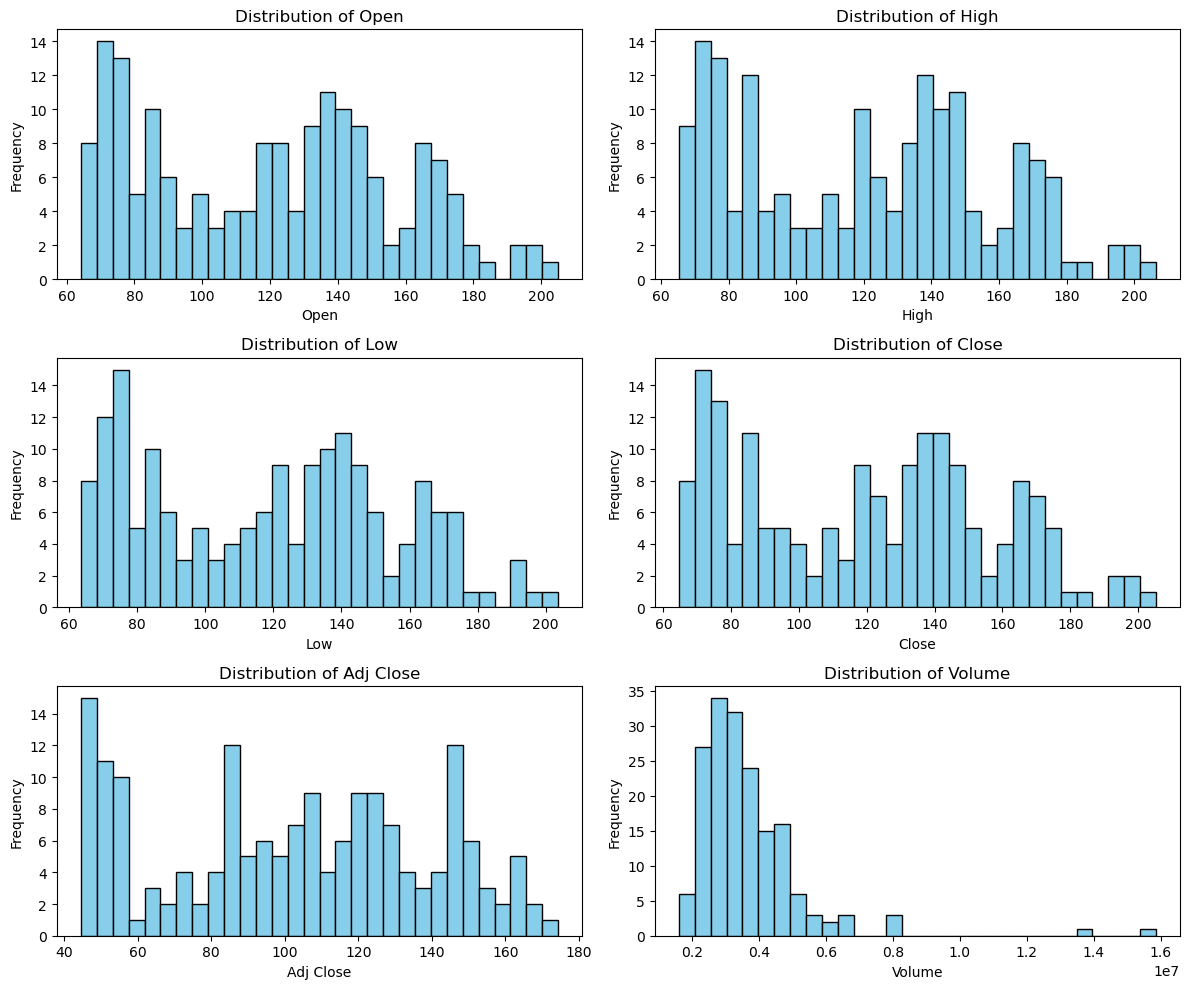

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for i, column in enumerate(numerical_columns):
    ax = axes[i]
    ax.hist(data[column], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
numerical_columns = [target_column]
data_to_normalize = data[numerical_columns]
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_to_normalize)
normalized_df = pd.DataFrame(normalized_data, columns=numerical_columns)
normalized_df['Date'] = data[date_column]
normalized_df.head()

,Close,Date
0,0.034513,2010-01-01
1,0.016098,2010-01-01
2,0.027389,2010-01-01
3,0.048392,2010-01-01
4,0.037251,2010-01-01


# Stationary Check

pValue of adfuller test is : 0.47893510205114037


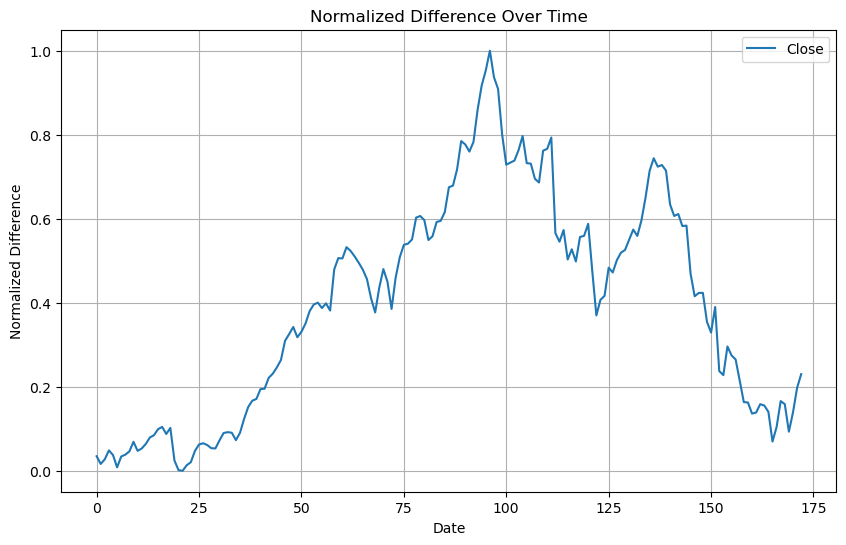

In [13]:
from statsmodels.tsa.stattools import adfuller
adftest=adfuller(normalized_df[target_column])
print('pValue of adfuller test is :',adftest[1])
plt.figure(figsize=(10, 6))
plt.plot(normalized_df.index, normalized_df[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Differencing

pValue of adfuller test is : 9.757718144580703e-21


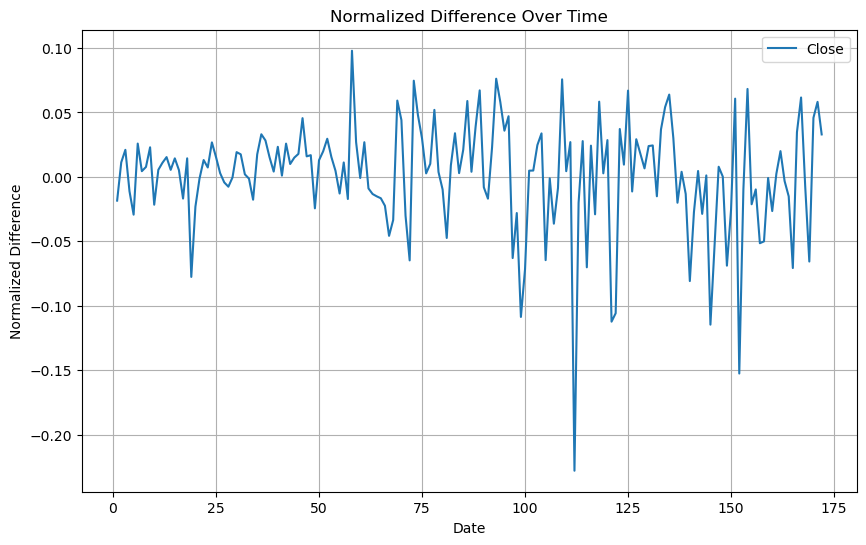

,Close,Date
1,-0.018414,2010-01-01
2,0.011291,2010-01-01
3,0.021003,2010-01-01
4,-0.011141,2010-01-01
5,-0.029287,2010-01-01
...,...,...
168,-0.007185,2024-01-01
169,-0.065658,2024-01-01
170,0.045852,2024-01-01
171,0.058216,2024-01-01


In [14]:
normalized_difference=normalized_df.copy()
for column in numerical_columns:
    normalized_difference[f'{column}'] = normalized_difference[column].diff()
normalized_difference.dropna(inplace=True)
adftest=adfuller(normalized_difference[target_column])
print('pValue of adfuller test is :',adftest[1])
plt.figure(figsize=(10, 6))
plt.plot(normalized_difference.index, normalized_difference[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()
normalized_difference

### Logarithim

pValue of adfuller test is : 0.2164087811279859


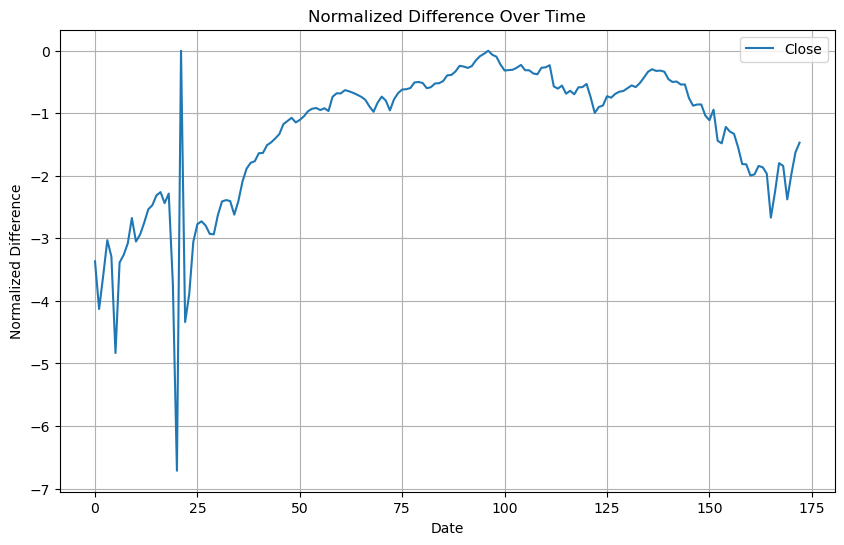

,Close,Date
0,-3.366432,2010-01-01
1,-4.129036,2010-01-01
2,-3.597615,2010-01-01
3,-3.028422,2010-01-01
4,-3.290066,2010-01-01
...,...,...
168,-1.841578,2024-01-01
169,-2.376133,2024-01-01
170,-1.974998,2024-01-01
171,-1.624666,2024-01-01


In [15]:
normalized_log=normalized_df
for column in numerical_columns:
    normalized_log[f'{column}'] = normalized_log[column].apply(lambda x: np.log(x) if x != 0 else 0)
adftest=adfuller(normalized_log[target_column])
print('pValue of adfuller test is :',adftest[1]) 
normalized_log.dropna(inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(normalized_log.index, normalized_log[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()
normalized_log

### Breakdown for Stationary Data
Upon testing both difference and logarithmic method i have choosen Loagrithem method because the p value is less then 0.05

In [16]:
# normalized_df=normalized_log
normalized_df=normalized_difference
adftest=adfuller(normalized_df[target_column])
print('pValue of adfuller test is :',adftest[1]) 

pValue of adfuller test is : 9.757718144580703e-21


## Arima Model

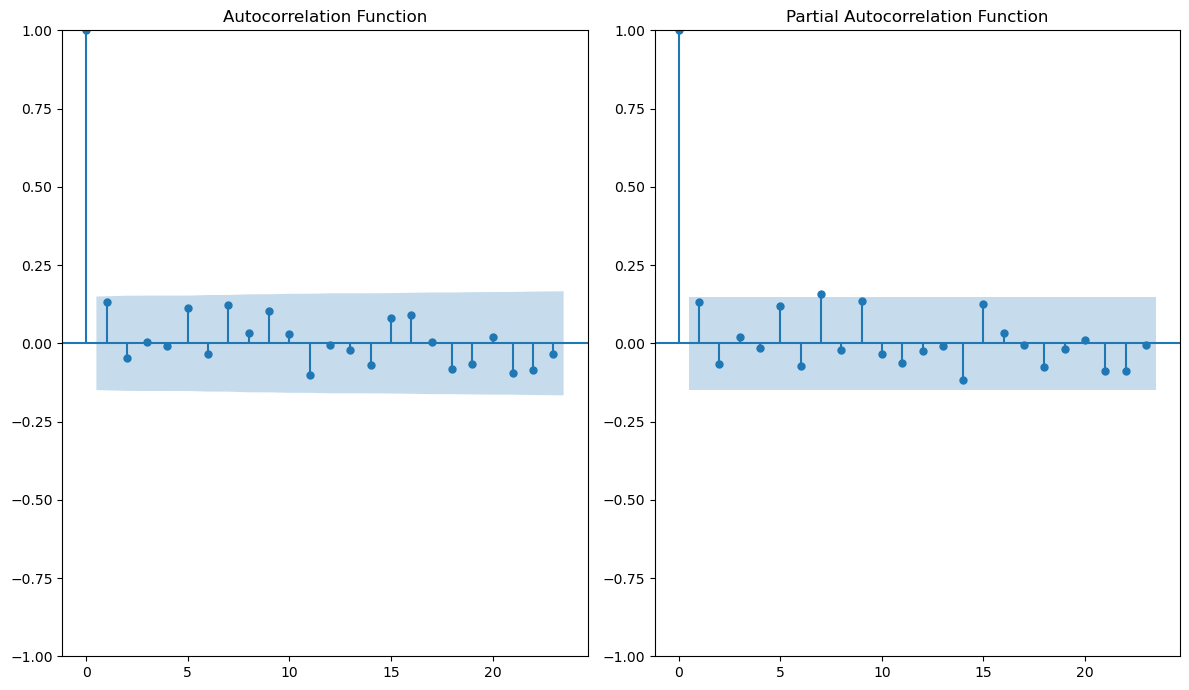

In [17]:
y = normalized_df[target_column]
lag_acf = acf(y, nlags=25)
lag_pacf = pacf(y, nlags=25, method='ols')
plt.figure(figsize=(12, 7))
plt.subplot(121)
plot_acf(y, ax=plt.gca())
plt.title('Autocorrelation Function')
plt.subplot(122)
plot_pacf(y, ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()


In [18]:
dummy=normalized_df.copy()
dummy['Date'] = pd.to_datetime(dummy['Date'])
dummy.set_index('Date', inplace=True)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(dummy[target_column], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print("Adfuller Output")
dfoutput

Results of Dickey-Fuller Test:
Adfuller Output


Test Statistic                -1.135550e+01
p-value                        9.757718e-21
#Lags Used                     0.000000e+00
Number of Observations Used    1.710000e+02
dtype: float64

## Evaluation

In [19]:
def evaluation(predictions, y_test):
    mse = mean_squared_error(y_test, predictions)
    r_squared = r2_score(y_test, predictions)
    rmse_arima = np.sqrt(mean_squared_error(y_test, predictions))
    mae_arima = mean_absolute_error(y_test, predictions)
    def mean_absolute_percentage_error(y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mape_arima = mean_absolute_percentage_error(y_test, predictions)
    return mse, r_squared, rmse_arima, mae_arima, mape_arima

## Splitting

In [20]:
X = normalized_df.drop(columns=['Date'])
y = normalized_df['Close']
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Arima 

In [21]:
order = (22, 1, 21)  
model = ARIMA(y_train, order=order)
fitted_model = model.fit()
predictions = fitted_model.forecast(steps=len(X_test))
mse, r_squared, rmse_arima, mae_arima, mape_arima = evaluation(predictions, y_test)
print("ARIMA Performance Metrics (Testing Set):")
print("MSE:",mse)
print("R-squared:", r_squared)
print("RMSE:", rmse_arima)
print("MAE:", mae_arima)
print("MAPE:", mape_arima)

ARIMA Performance Metrics (Testing Set):
MSE: 0.0031513052018111937
R-squared: -0.26869146426418156
RMSE: 0.056136487259279
MAE: 0.043819337431015855
MAPE: 401.870954583962


### Actual VS Predicted Testing DATASET

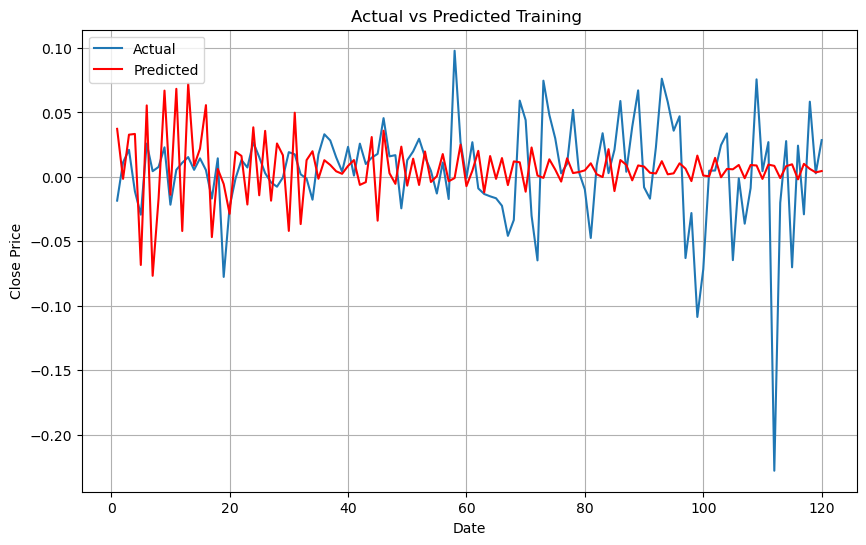

In [22]:
predictions_training = fitted_model.forecast(steps=len(X_train))
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train.values, label='Actual')
plt.plot(y_train.index, predictions_training, color='red', label='Predicted')
plt.title('Actual vs Predicted Training ')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

### Actual VS Predicted Testing DATASET

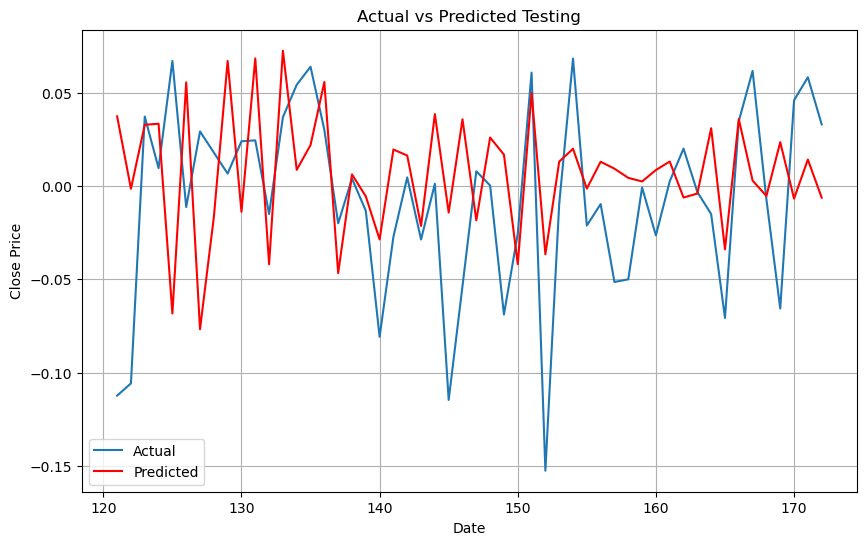

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, predictions, color='red', label='Predicted')
plt.title('Actual vs Predicted Testing')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

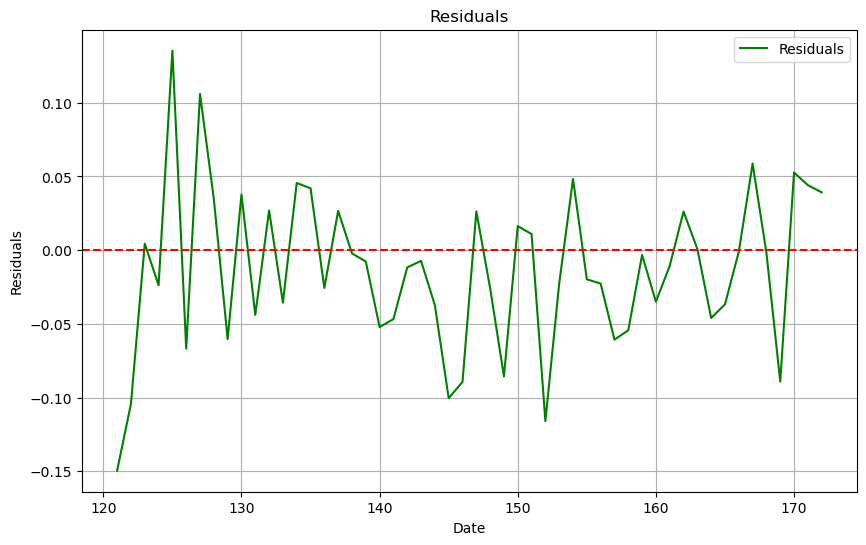

In [24]:
residuals = y_test.values - predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, residuals, color='green', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# SARIMA

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

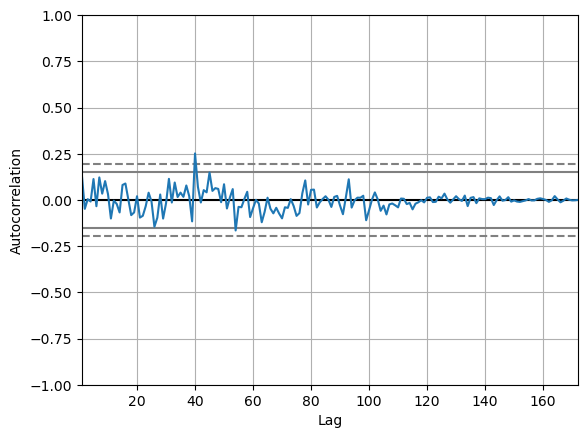

In [25]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(normalized_df['Close'])

In [26]:
normalized_df

,Close,Date
1,-0.018414,2010-01-01
2,0.011291,2010-01-01
3,0.021003,2010-01-01
4,-0.011141,2010-01-01
5,-0.029287,2010-01-01
...,...,...
168,-0.007185,2024-01-01
169,-0.065658,2024-01-01
170,0.045852,2024-01-01
171,0.058216,2024-01-01


<Figure size 640x480 with 0 Axes>

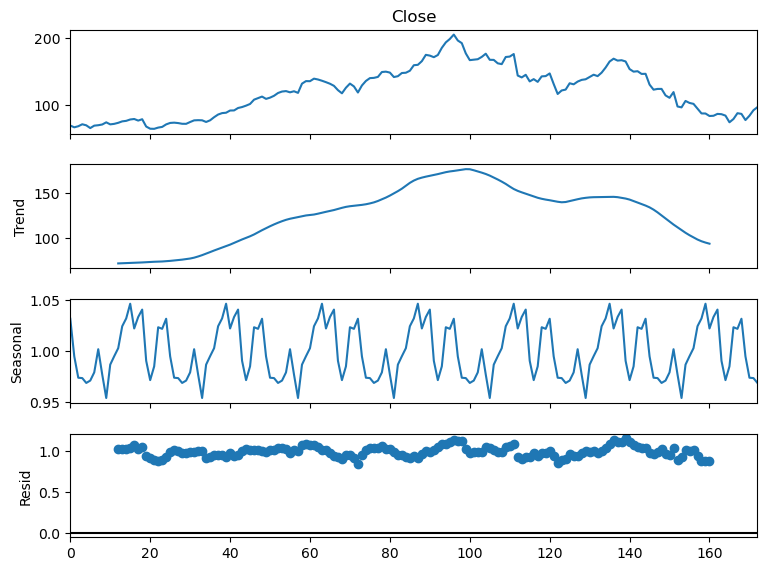

In [27]:
result = seasonal_decompose(data["Close"], model='multiplicative', period=24)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8, 6)
fig.show()

In [28]:
normalized_df

,Close,Date
1,-0.018414,2010-01-01
2,0.011291,2010-01-01
3,0.021003,2010-01-01
4,-0.011141,2010-01-01
5,-0.029287,2010-01-01
...,...,...
168,-0.007185,2024-01-01
169,-0.065658,2024-01-01
170,0.045852,2024-01-01
171,0.058216,2024-01-01


In [29]:
adf_result = adfuller(normalized_df['Close'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -11.3554974847553
p-value: 9.757718144580703e-21


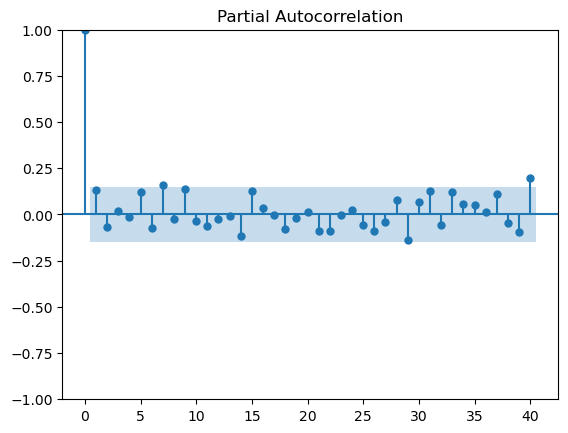

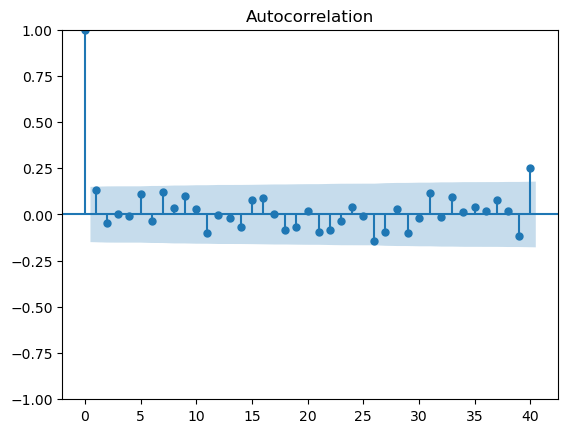

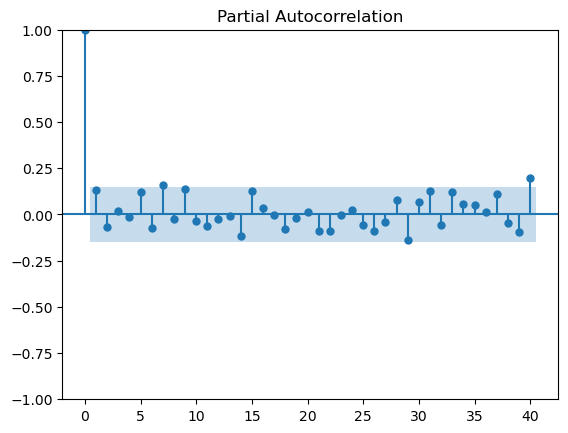

In [30]:
plot_acf(normalized_df['Close'], lags=40)
plot_pacf(normalized_df['Close'], lags=40)

In [31]:
import pmdarima as pmd

model=pmd.auto_arima(normalized_df['Close'],start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-591.537, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-589.925, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-589.016, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-589.433, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-591.806, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-587.929, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-587.928, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-585.935, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-590.991, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-591.405, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-595.537, Time=0.17 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-593.541, Time=0.43 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-593.540, Time=0.52 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-593.676, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0

In [32]:
sarima_model = SARIMAX(y_train, order=(21, 1, 1), seasonal_order=(0, 0, 0, 12))
fitted_sarima_model = sarima_model.fit()

In [33]:
sarima_predictions = fitted_sarima_model.forecast(steps=len(X_test))
mse, r_squared, rmse_sarima, mae_sarima, mape_sarima = evaluation(sarima_predictions, y_test)
print("SARIMA Performance Metrics (Testing Set):")
print("R-squared:", r_squared)
print("RMSE:", rmse_sarima)
print("MAE:", mae_sarima)
print("MAPE:", mape_sarima)

SARIMA Performance Metrics (Testing Set):
R-squared: -0.0375452504920748
RMSE: 0.05076574308259619
MAE: 0.03836787820410093
MAPE: 373.0375168999606


### Sarima on training Dataset

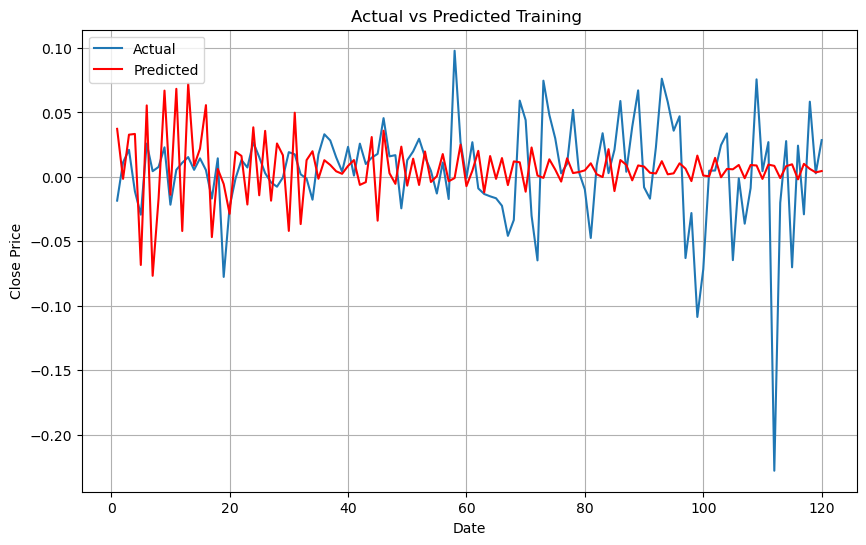

In [34]:
sarima_predictions_training = fitted_model.forecast(steps=len(X_train))
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train.values, label='Actual')
plt.plot(y_train.index, sarima_predictions_training, color='red', label='Predicted')
plt.title('Actual vs Predicted Training ')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

### Sarima on testing Dataset

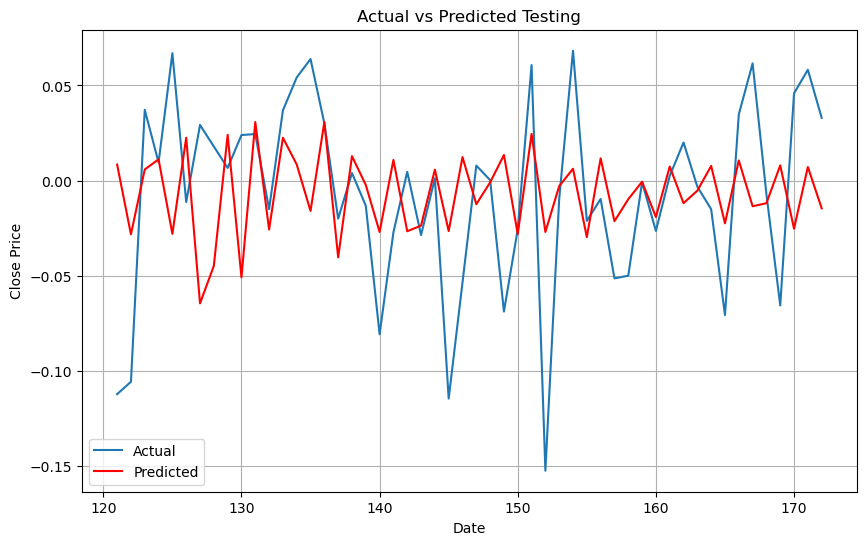

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, sarima_predictions, color='red', label='Predicted')
plt.title('Actual vs Predicted Testing')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

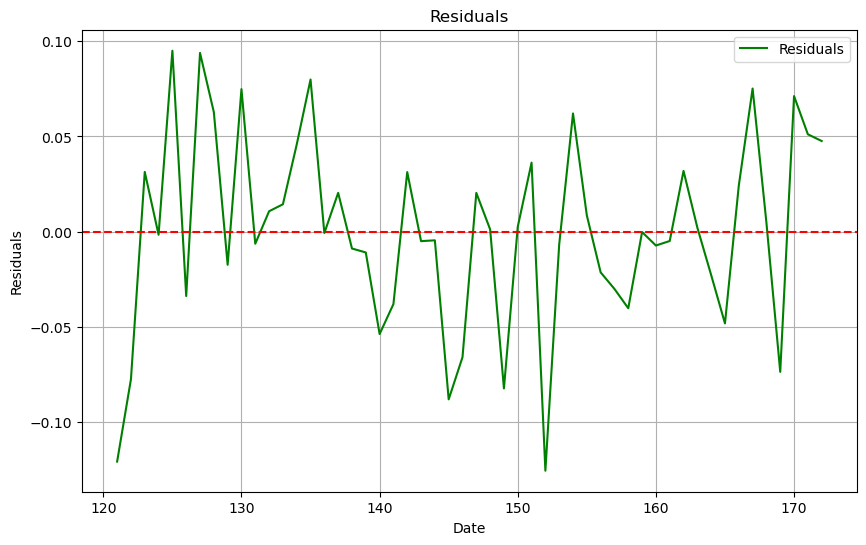

In [36]:
residuals = y_test.values - sarima_predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, residuals, color='green', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model):
    # Perform cross-validation
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
    
    # Calculate metrics
    mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
    mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
    rmse = np.sqrt(mse)
    r_squared = r2_score(df_cv['y'], df_cv['yhat'])
    
    # Calculate MAPE
    def mean_absolute_percentage_error(y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mape = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
    
    return mae, mse, rmse, r_squared, mape, df_cv

prophet_df = normalized_df.rename(columns={"Close": "y", "Date": "ds"})
model = Prophet(seasonality_mode='additive', changepoint_prior_scale=0.5) 
model.fit(prophet_df)  
mae, mse, rmse, r_squared, mape, df_cv = evaluate_model(model)


20:26:34 - cmdstanpy - INFO - Chain [1] start processing
20:26:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/23 [00:00<?, ?it/s]

20:26:34 - cmdstanpy - INFO - Chain [1] start processing
20:26:34 - cmdstanpy - INFO - Chain [1] done processing
20:26:34 - cmdstanpy - INFO - Chain [1] start processing
20:26:35 - cmdstanpy - INFO - Chain [1] done processing
20:26:35 - cmdstanpy - INFO - Chain [1] start processing
20:26:35 - cmdstanpy - INFO - Chain [1] done processing
20:26:35 - cmdstanpy - INFO - Chain [1] start processing
20:26:35 - cmdstanpy - INFO - Chain [1] done processing
20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:36 - cmdstanpy - INFO - Chain [1] done processing
20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:37 - cmdstanpy - INFO - Chain [1] done processing
20:26:37 - cmdstanpy - INFO - Chain [1] start processing
20:26:37 - cmdstanpy - INFO - Chain [1] done processing
20:26:37 - cmdstanpy - INFO - Chain [1] start processing
20:26:37 - cmdstanpy - INFO - Chain [1] done processing
20:26:38 - cmdstanpy - INFO - Chain [1] start processing
20:26:38 - cmdstanpy - INFO - Chain [1]

In [43]:

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r_squared)
print("Mean Absolute Percentage Error (MAPE):", mape)




Mean Absolute Error (MAE): 0.03800626352072861
Mean Squared Error (MSE): 0.0024753309230488236
Root Mean Squared Error (RMSE): 0.049752697645945025
R-squared (R2): -0.1116221656068257
Mean Absolute Percentage Error (MAPE): 240.74686219129705


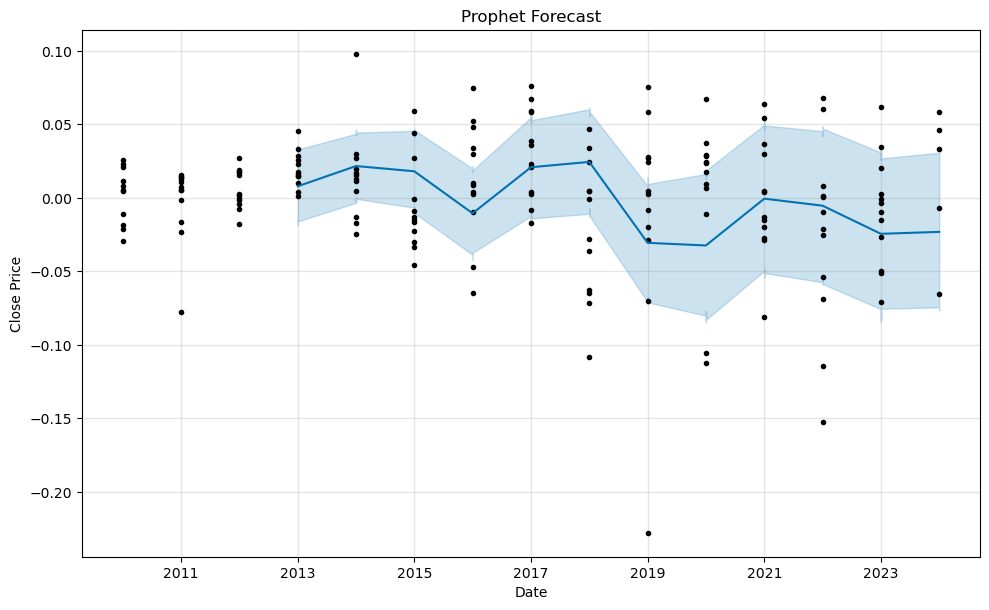

In [44]:
# Plot the forecast
fig = model.plot(df_cv)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Prophet Forecast')
plt.show()


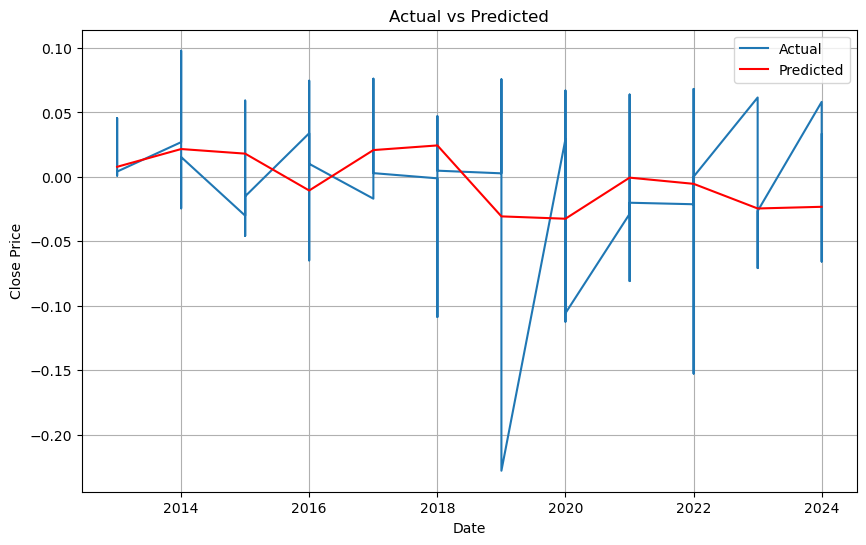

In [45]:

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(df_cv['ds'], df_cv['y'], label='Actual')
plt.plot(df_cv['ds'], df_cv['yhat'], color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


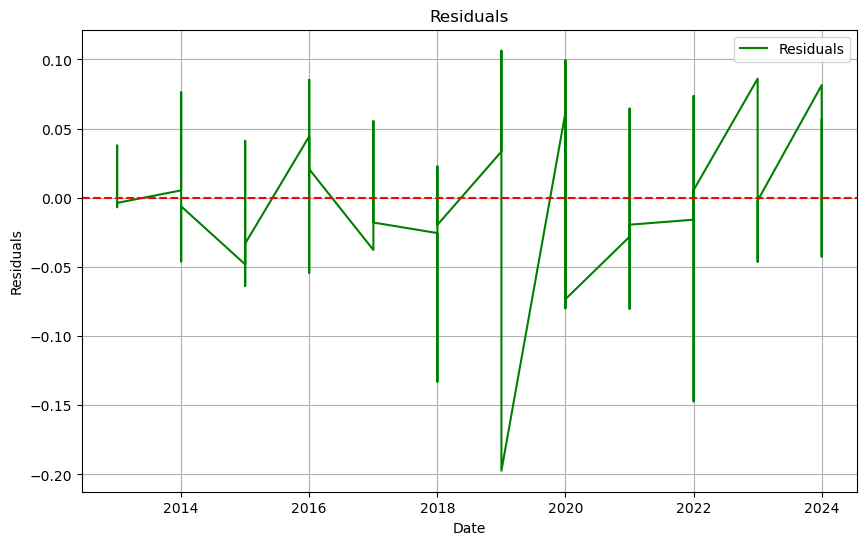

In [46]:

# Calculate residuals
residuals = df_cv['y'] - df_cv['yhat']

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(df_cv['ds'], residuals, color='green', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()